In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ===== CELL 1: Import Libraries =====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import tensorflow as tf
from pathlib import Path
from PIL import Image
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix,
                            precision_recall_curve, average_precision_score,
                            roc_curve, auc)
from skimage.feature import graycomatrix, graycoprops
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')
sns.set(font_scale=1.4)

In [ ]:
# ===== CELL 2: Parameters =====
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
SEED = 58
DATASET_PATH = "/kaggle/input/potato-leaf-disease-original-augmented/Dataset"


In [ ]:
# ===== CELL 3: Load Dataset =====
dataset = image_dataset_from_directory(
    DATASET_PATH,
    seed=SEED,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)
class_names = dataset.class_names
print("Classes:", class_names)


Found 5236 files belonging to 7 classes.


I0000 00:00:1765695331.969125      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765695331.969790      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Classes: ['Bacteria', 'Fungi', 'Healthy', 'Nematode', 'Pest', 'Phytopthora', 'Virus']


In [ ]:

# ===== CELL 4: Detailed Image Info DataFrame =====
print("Extracting detailed image information...")
image_info = []
folders = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]

for cls in tqdm(folders, desc="Processing classes"):
    folder_path = Path(DATASET_PATH) / cls
    for img_path in list(folder_path.glob("*"))[:500]:  # Limit for performance
        try:
            img = Image.open(img_path).convert("RGB")
            w, h = img.size
            img_np = np.array(img)

            # Calculate GLCM texture features
            gray = np.array(img.convert('L'))
            gray_resized = np.resize(gray, (min(gray.shape[0], 100), min(gray.shape[1], 100)))
            glcm = graycomatrix(gray_resized, [1], [0], levels=256, symmetric=True, normed=True)

            image_info.append({
                "class": cls,
                "width": w,
                "height": h,
                "aspect_ratio": w / h,
                "mean_R": img_np[:,:,0].mean(),
                "mean_G": img_np[:,:,1].mean(),
                "mean_B": img_np[:,:,2].mean(),
                "std_R": img_np[:,:,0].std(),
                "std_G": img_np[:,:,1].std(),
                "std_B": img_np[:,:,2].std(),
                "contrast": graycoprops(glcm, 'contrast')[0, 0],
                "dissimilarity": graycoprops(glcm, 'dissimilarity')[0, 0],
                "homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
                "energy": graycoprops(glcm, 'energy')[0, 0],
                "correlation": graycoprops(glcm, 'correlation')[0, 0]
            })
        except Exception as e:
            continue

df_info = pd.DataFrame(image_info)
print(f"\nDataset Info Shape: {df_info.shape}")
print("\nFirst few rows:")
print(df_info.head())
print("\nStatistical Summary:")
print(df_info.describe())


Extracting detailed image information...


Processing classes: 100%|██████████| 7/7 [03:58<00:00, 34.12s/it]


Dataset Info Shape: (3500, 15)

First few rows:
      class  width  height  aspect_ratio      mean_R      mean_G      mean_B  \
0  Nematode   1500    1500           1.0  114.640941  131.221694   67.189256   
1  Nematode   1500    1500           1.0  108.963570  111.420648   79.601360   
2  Nematode   1500    1500           1.0  143.210527  149.056861  120.254445   
3  Nematode   1500    1500           1.0  143.955048  136.813873   52.824290   
4  Nematode   1500    1500           1.0  128.375367  122.679310   70.376476   

       std_R      std_G      std_B   contrast  dissimilarity  homogeneity  \
0  57.440126  58.925707  35.527692  65.705253       4.513535     0.361668   
1  62.756625  60.519209  51.606094   6.823030       1.652727     0.503418   
2  57.904640  53.729664  73.696586   2.627778       0.849798     0.698468   
3  49.037340  40.194920  53.645233   5.283838       1.527273     0.520480   
4  66.587393  50.578301  39.183979   3.475758       1.183636     0.576126   

     en


Class Distribution:
         Class  Count  Percentage  Imbalance_Ratio
0     Bacteria    748       14.29              1.0
1        Fungi    748       14.29              1.0
2      Healthy    748       14.29              1.0
3     Nematode    748       14.29              1.0
4         Pest    748       14.29              1.0
5  Phytopthora    748       14.29              1.0
6        Virus    748       14.29              1.0


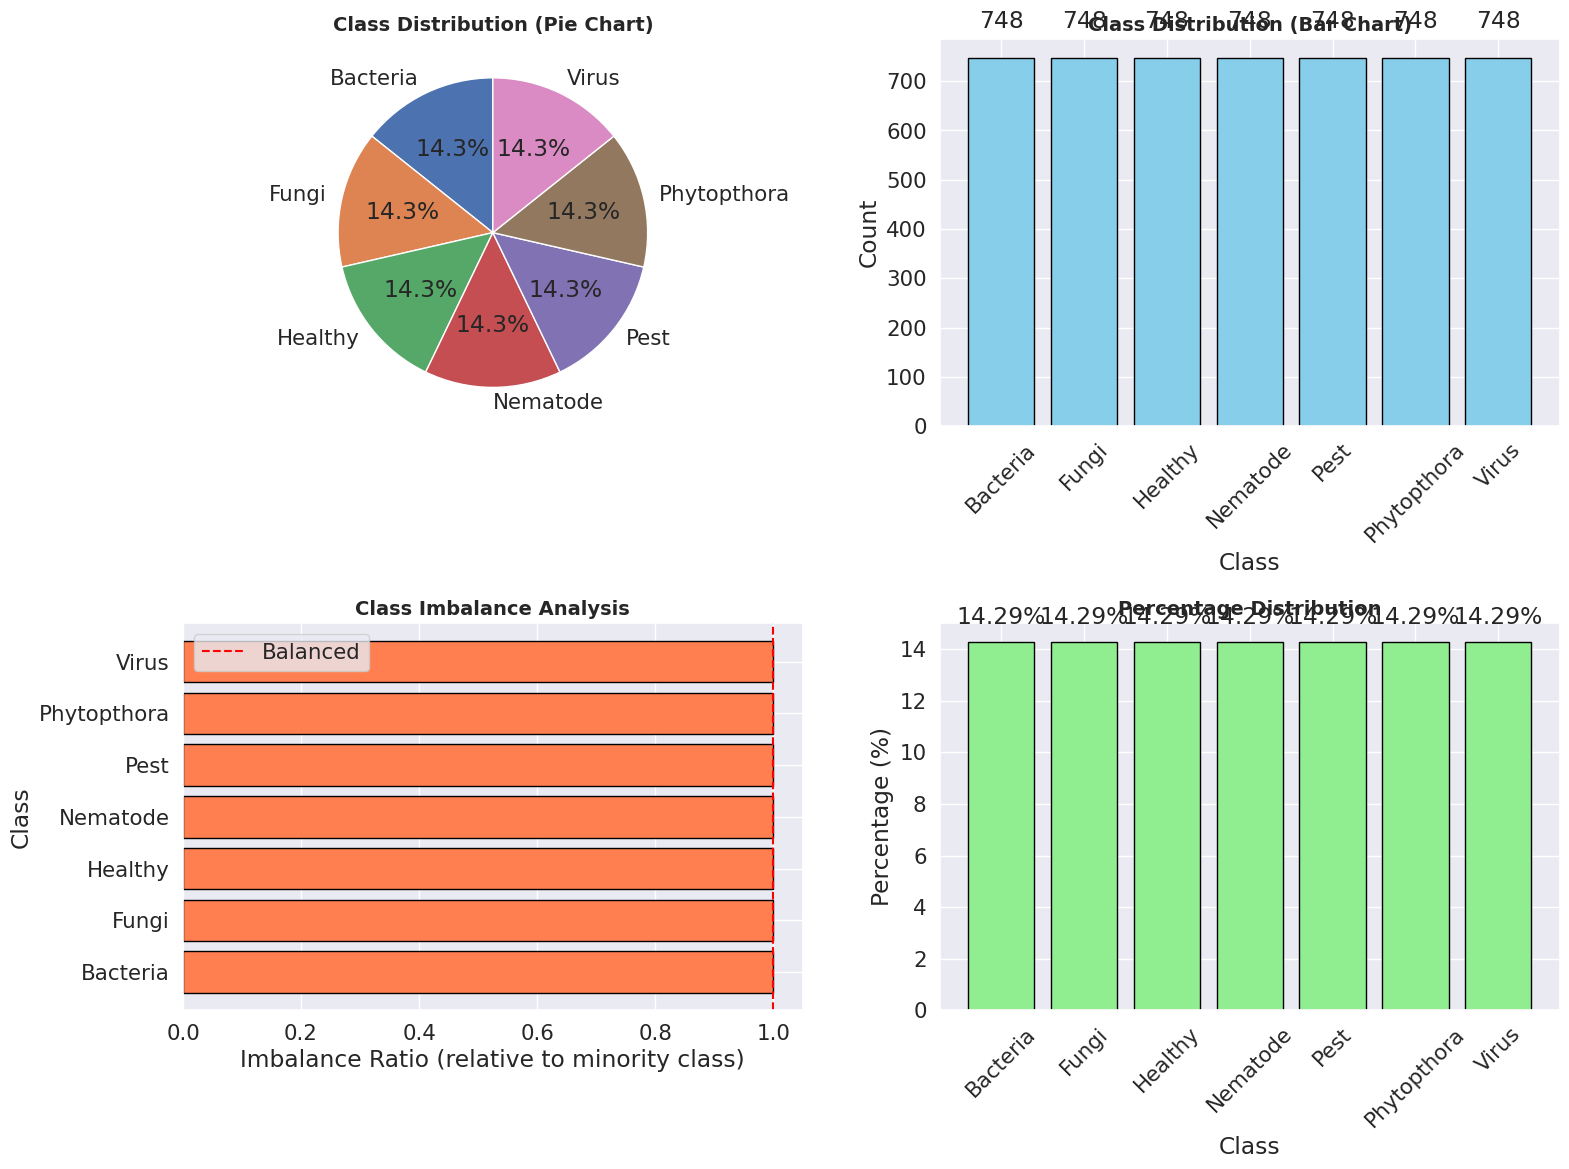

In [ ]:

# ===== CELL 5: Class Distribution & Imbalance Analysis =====
def get_all_labels(ds):
    labels = []
    for _, labels_batch in ds:
        labels.extend(labels_batch.numpy())
    return labels

labels = get_all_labels(dataset)
class_counts = {class_name: 0 for class_name in class_names}
for label in labels:
    class_counts[class_names[label]] += 1

# Class Imbalance Analysis
df_class = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])
df_class['Percentage'] = (df_class['Count'] / df_class['Count'].sum() * 100).round(2)
df_class['Imbalance_Ratio'] = (df_class['Count'] / df_class['Count'].min()).round(2)

print("\nClass Distribution:")
print(df_class)

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pie Chart
axes[0, 0].pie(df_class['Count'], labels=df_class['Class'], autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Class Distribution (Pie Chart)', fontsize=14, fontweight='bold')

# Bar Chart with counts
axes[0, 1].bar(df_class['Class'], df_class['Count'], color='skyblue', edgecolor='black')
axes[0, 1].set_xlabel('Class')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Class Distribution (Bar Chart)', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_class['Count']):
    axes[0, 1].text(i, v + 50, str(v), ha='center', va='bottom')

# Imbalance Ratio
axes[1, 0].barh(df_class['Class'], df_class['Imbalance_Ratio'], color='coral', edgecolor='black')
axes[1, 0].set_xlabel('Imbalance Ratio (relative to minority class)')
axes[1, 0].set_ylabel('Class')
axes[1, 0].set_title('Class Imbalance Analysis', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=1, color='red', linestyle='--', label='Balanced')
axes[1, 0].legend()

# Percentage distribution
axes[1, 1].bar(df_class['Class'], df_class['Percentage'], color='lightgreen', edgecolor='black')
axes[1, 1].set_xlabel('Class')
axes[1, 1].set_ylabel('Percentage (%)')
axes[1, 1].set_title('Percentage Distribution', fontsize=14, fontweight='bold')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, v in enumerate(df_class['Percentage']):
    axes[1, 1].text(i, v + 0.5, f'{v}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Generating RGB Color Histograms...


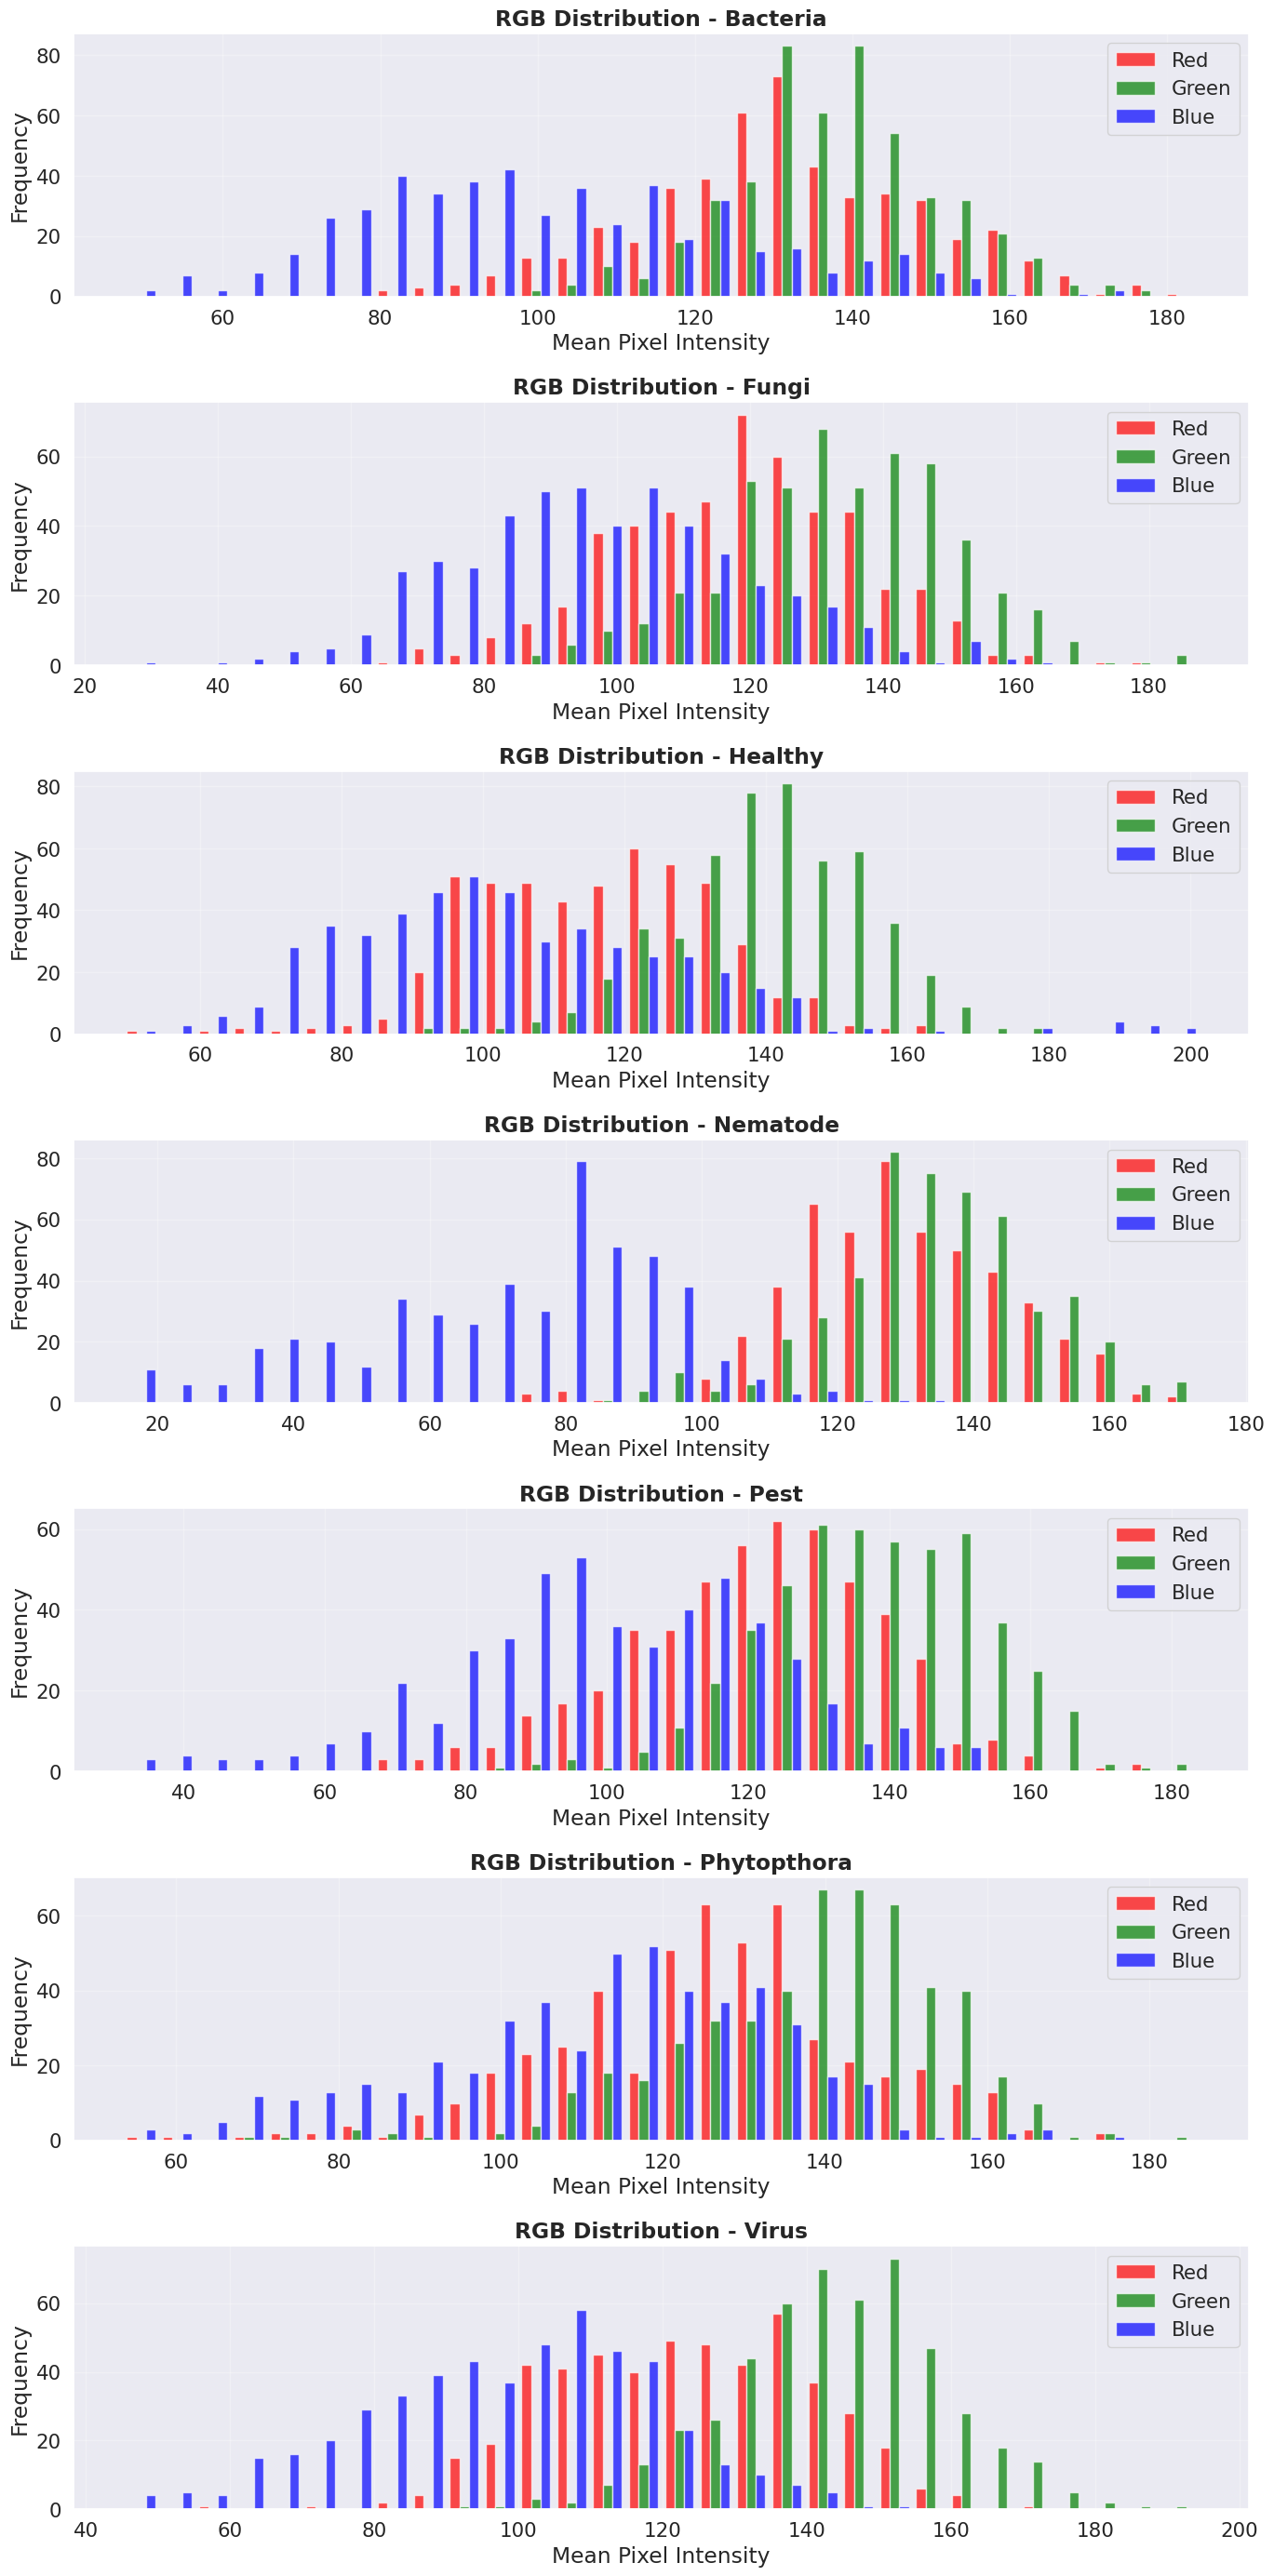

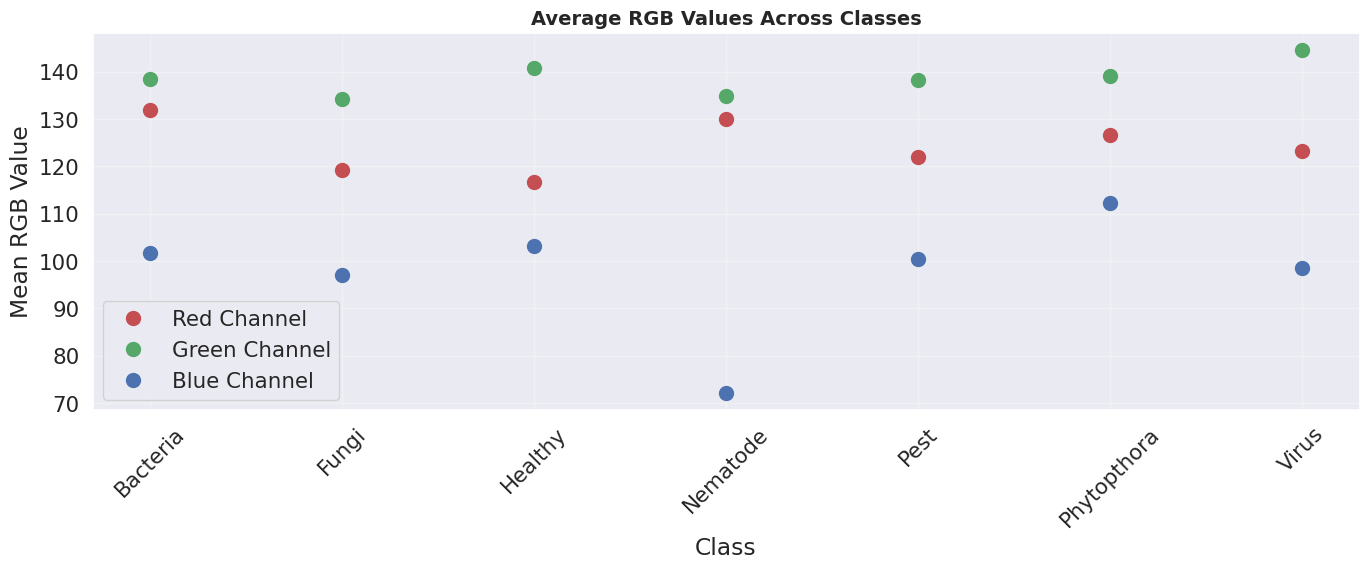

In [ ]:

# ===== CELL 6: RGB Color Histogram Analysis =====
print("\nGenerating RGB Color Histograms...")
fig, axes = plt.subplots(len(class_names), 1, figsize=(14, 4*len(class_names)))
if len(class_names) == 1:
    axes = [axes]

for idx, cls in enumerate(class_names):
    cls_data = df_info[df_info['class'] == cls]
    axes[idx].hist([cls_data['mean_R'], cls_data['mean_G'], cls_data['mean_B']],
                   bins=30, label=['Red', 'Green', 'Blue'], alpha=0.7, color=['red', 'green', 'blue'])
    axes[idx].set_xlabel('Mean Pixel Intensity')
    axes[idx].set_ylabel('Frequency')
    axes[idx].set_title(f'RGB Distribution - {cls}', fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Overall RGB comparison
plt.figure(figsize=(14, 6))
for cls in class_names:
    cls_data = df_info[df_info['class'] == cls]
    plt.plot(cls, cls_data['mean_R'].mean(), 'ro', markersize=10, label=f'{cls} - R' if cls == class_names[0] else '')
    plt.plot(cls, cls_data['mean_G'].mean(), 'go', markersize=10, label=f'{cls} - G' if cls == class_names[0] else '')
    plt.plot(cls, cls_data['mean_B'].mean(), 'bo', markersize=10, label=f'{cls} - B' if cls == class_names[0] else '')
plt.xlabel('Class')
plt.ylabel('Mean RGB Value')
plt.title('Average RGB Values Across Classes', fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.legend(['Red Channel', 'Green Channel', 'Blue Channel'])
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

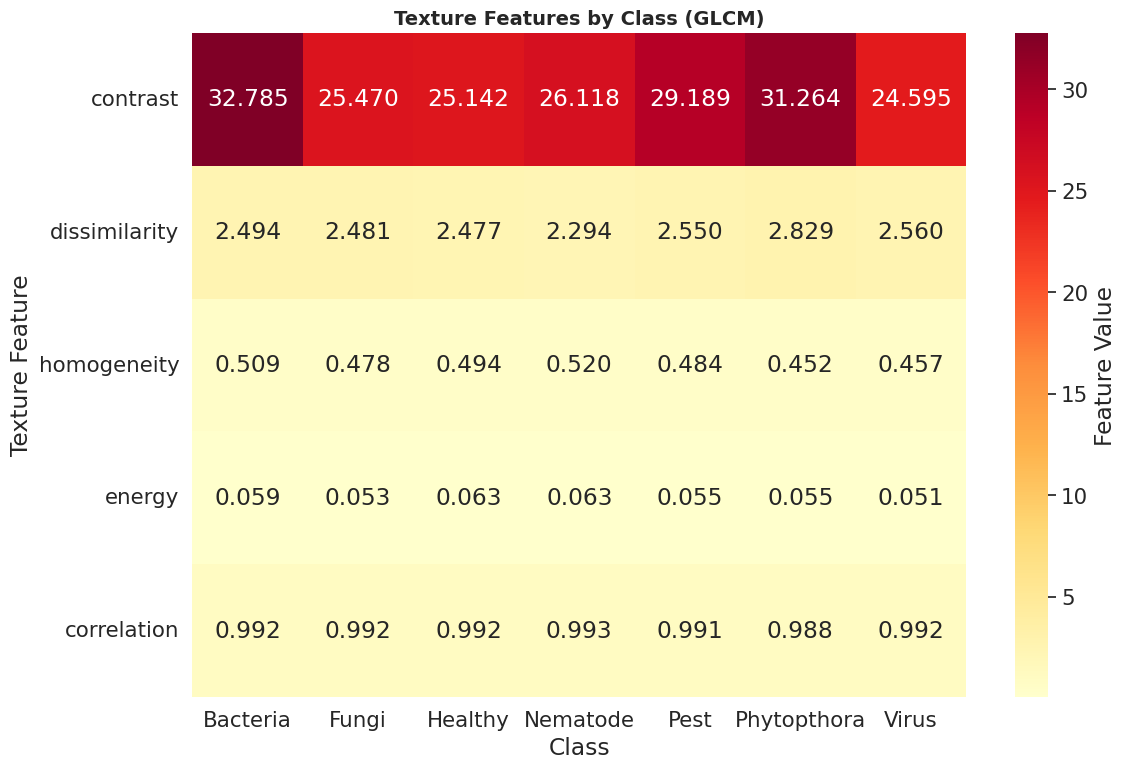

In [ ]:

# ===== CELL 7: Texture Features Heatmap =====
texture_features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
texture_df = df_info.groupby('class')[texture_features].mean()

plt.figure(figsize=(12, 8))
sns.heatmap(texture_df.T, annot=True, fmt='.3f', cmap='YlOrRd', cbar_kws={'label': 'Feature Value'})
plt.title('Texture Features by Class (GLCM)', fontweight='bold', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Texture Feature')
plt.tight_layout()
plt.show()


Performing PCA on image features...


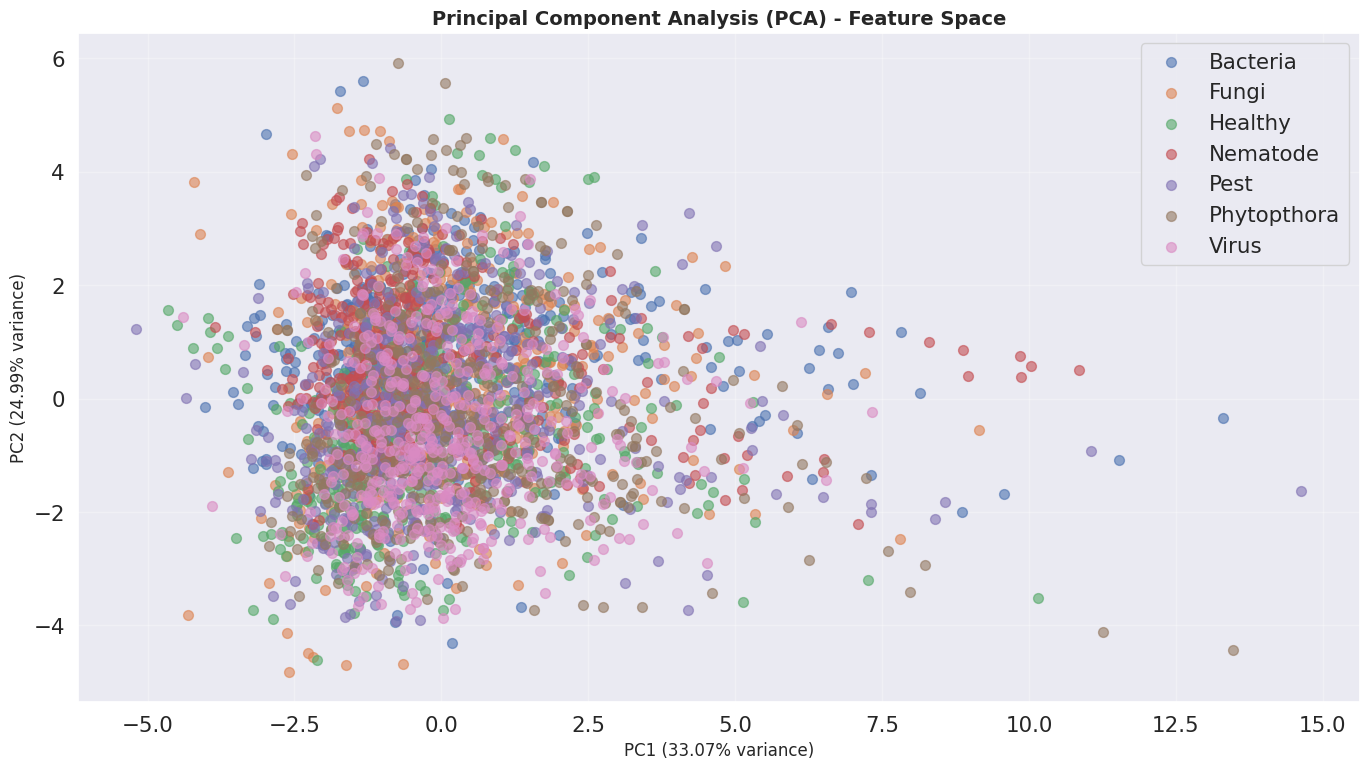

Explained variance ratio: [0.33073696 0.24994834]
Total variance explained: 58.07%


In [ ]:

# ===== CELL 8: Principal Component Analysis (PCA) =====
print("\nPerforming PCA on image features...")
feature_cols = ['mean_R', 'mean_G', 'mean_B', 'std_R', 'std_G', 'std_B',
                'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
X_features = df_info[feature_cols].values
y_classes = df_info['class'].values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_features)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create PCA DataFrame
pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
pca_df['class'] = y_classes

# Visualization
plt.figure(figsize=(14, 8))
for cls in class_names:
    cls_data = pca_df[pca_df['class'] == cls]
    plt.scatter(cls_data['PC1'], cls_data['PC2'], label=cls, alpha=0.6, s=50)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% variance)', fontsize=12)
plt.title('Principal Component Analysis (PCA) - Feature Space', fontweight='bold', fontsize=14)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {sum(pca.explained_variance_ratio_)*100:.2f}%")



Calculating inter-class feature similarity...


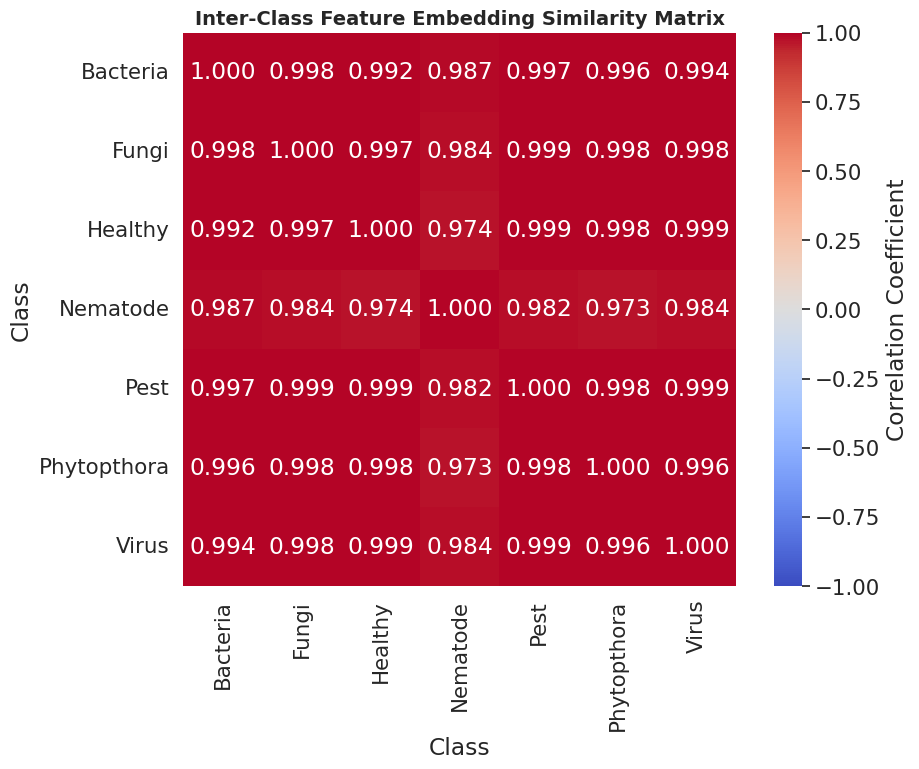

In [ ]:

# ===== CELL 9: Inter-Class Feature Similarity Matrix =====
print("\nCalculating inter-class feature similarity...")
class_features = df_info.groupby('class')[feature_cols].mean()
correlation_matrix = class_features.T.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.3f', cmap='coolwarm',
            center=0, vmin=-1, vmax=1, square=True,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Inter-Class Feature Embedding Similarity Matrix', fontweight='bold', fontsize=14)
plt.xlabel('Class')
plt.ylabel('Class')
plt.tight_layout()
plt.show()

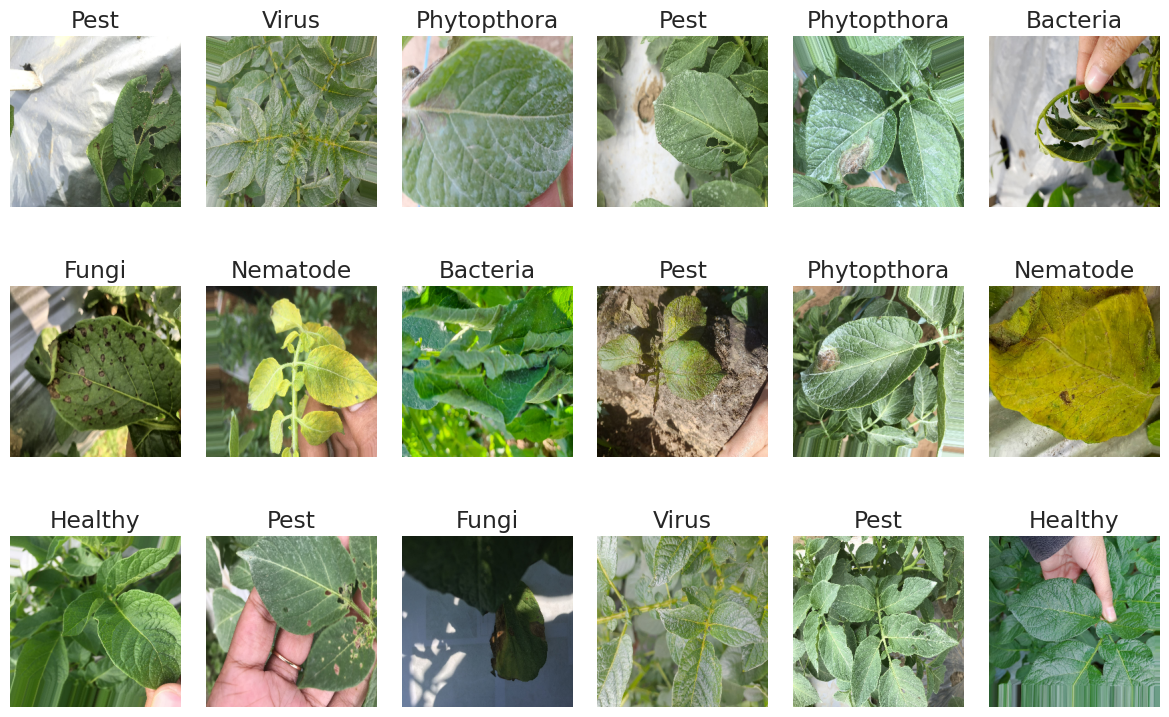

In [ ]:

# ===== CELL 10: Visualize Sample Images =====
plt.figure(figsize=(12, 8))
for images, labels in dataset.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:

# ===== CELL 11: Split Dataset =====
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=SEED)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)
print(f"Train batches: {len(train_ds)}, Val batches: {len(val_ds)}, Test batches: {len(test_ds)}")


Train batches: 131, Val batches: 16, Test batches: 17


In [ ]:

# ===== CELL 12: Optimize Performance =====
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [ ]:

# ===== CELL 13: Build Model =====
def create_efficientnet_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), num_classes=7):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        BatchNormalization(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

model = create_efficientnet_model(num_classes=len(class_names))
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,417,450 (16.85 MB)

 Trainable params: 364,807 (1.39 MB)

 Non-trainable params: 4,052,643 (15.46 MB)

In [ ]:

# ===== CELL 14: Train Model =====
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50


I0000 00:00:1765695635.359754     117 service.cc:148] XLA service 0x78c164014290 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765695635.360887     117 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765695635.360908     117 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765695637.353233     117 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1765695639.860220     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765695640.045709     117 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  3/131 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - accuracy: 0.1215 - loss: 2.4987   

I0000 00:00:1765695648.834912     117 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 11/131 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.1402 - loss: 2.3904

E0000 00:00:1765695652.623872     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765695652.789702     116 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


131/131 ━━━━━━━━━━━━━━━━━━━━ 89s 339ms/step - accuracy: 0.2202 - loss: 2.1179 - val_accuracy: 0.5996 - val_loss: 1.4647
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.5093 - loss: 1.3542 - val_accuracy: 0.7227 - val_loss: 1.0459
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - accuracy: 0.5990 - loss: 1.1311 - val_accuracy: 0.7715 - val_loss: 0.7792
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.6505 - loss: 0.9809 - val_accuracy: 0.8027 - val_loss: 0.6351
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - accuracy: 0.6840 - loss: 0.8813 - val_accuracy: 0.8301 - val_loss: 0.5565
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - accuracy: 0.7260 - loss: 0.7930 - val_accuracy: 0.8418 - val_loss: 0.5014
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.7248 - loss: 0.7529 - val_accuracy: 0.8594 - val_loss: 0.4597
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.7567 - loss: 0.6989 - val_accuracy: 0.8

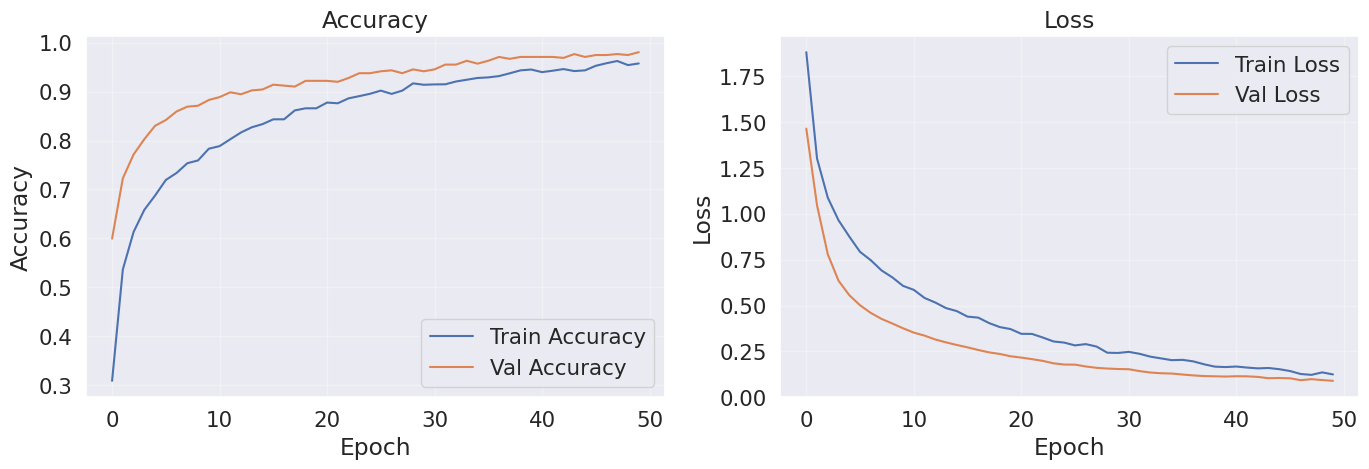

In [ ]:

# ===== CELL 15: Plot Training Curves =====
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training(history)

In [ ]:

# ===== CELL 16: Evaluate Model =====
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9650 - loss: 0.1117

Test Loss: 0.1034
Test Accuracy: 0.9651


In [ ]:

# ===== CELL 17: Get Predictions for Advanced Metrics =====
y_true = []
y_pred = []
y_pred_proba = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred_proba.extend(preds)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_proba = np.array(y_pred_proba)

In [ ]:

# ===== CELL 18: Classification Report =====
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report:

              precision    recall  f1-score   support

    Bacteria       0.98      0.98      0.98        87
       Fungi       0.91      0.95      0.93        73
     Healthy       0.97      0.99      0.98        77
    Nematode       0.99      1.00      0.99        80
        Pest       0.95      0.91      0.93        76
 Phytopthora       0.99      0.96      0.97        75
       Virus       0.97      0.97      0.97        76

    accuracy                           0.97       544
   macro avg       0.96      0.96      0.96       544
weighted avg       0.97      0.97      0.97       544



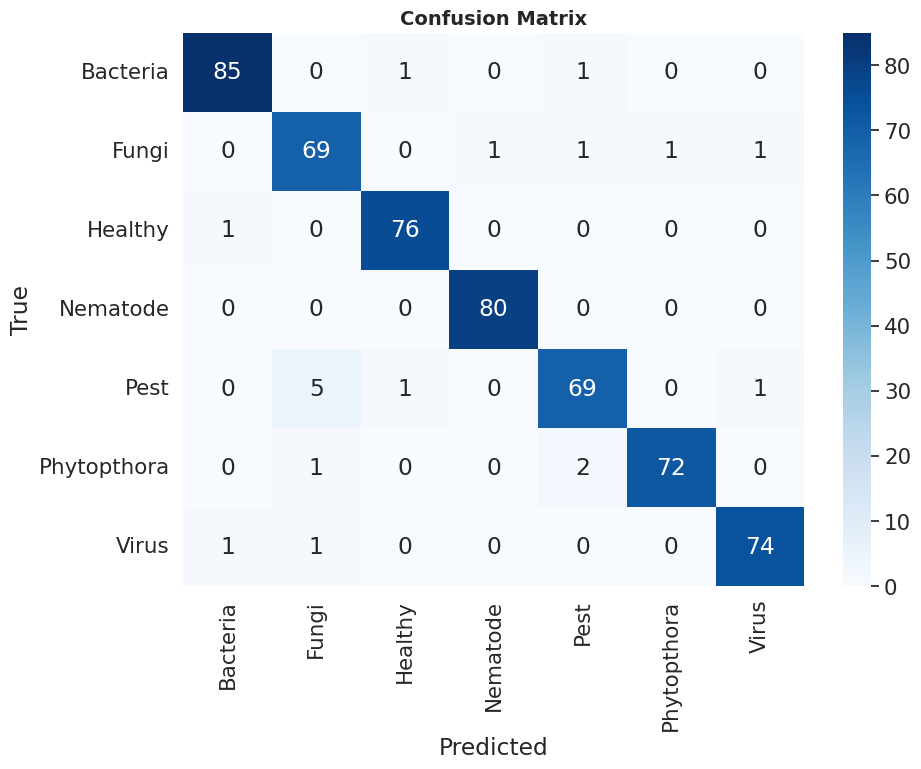

In [ ]:

# ===== CELL 19: Confusion Matrix =====
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix", fontweight='bold', fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


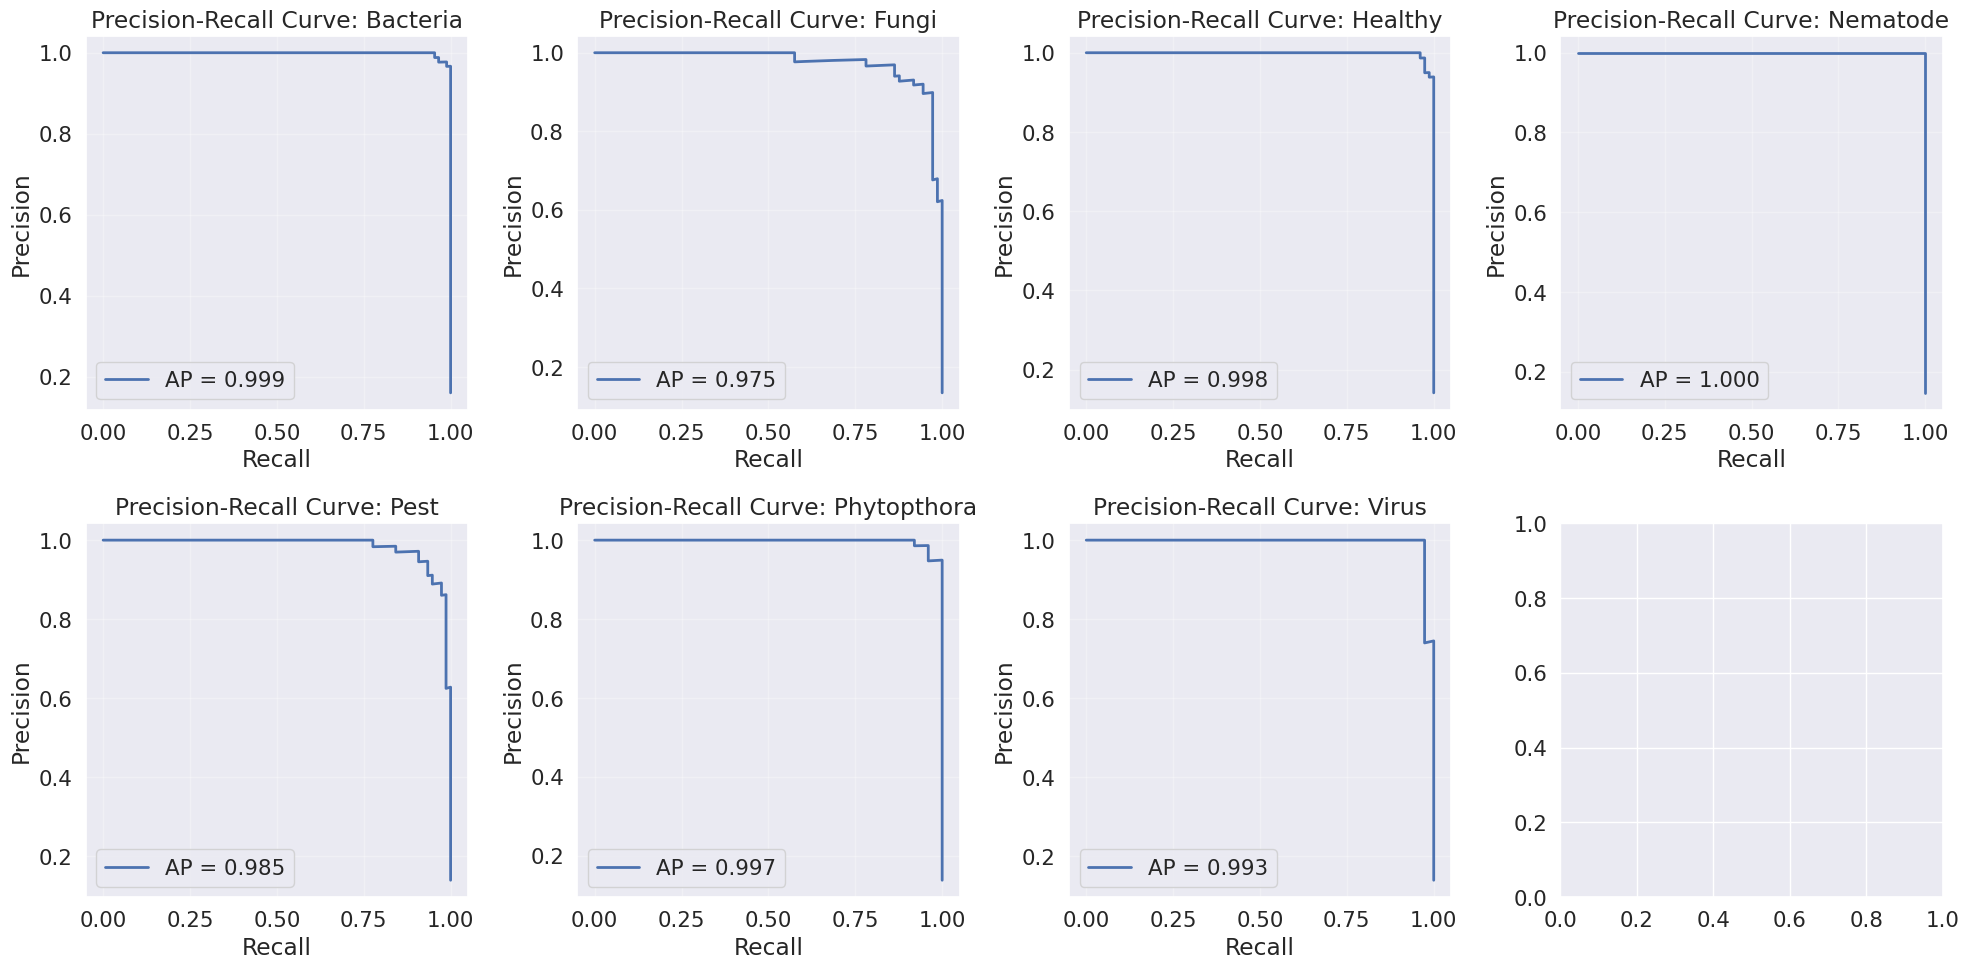

In [ ]:

# ===== CELL 20: Precision-Recall Curves =====
from sklearn.preprocessing import label_binarize
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, cls in enumerate(class_names):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_proba[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], y_pred_proba[:, i])

    axes[i].plot(recall, precision, linewidth=2, label=f'AP = {avg_precision:.3f}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
    axes[i].set_title(f'Precision-Recall Curve: {cls}')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

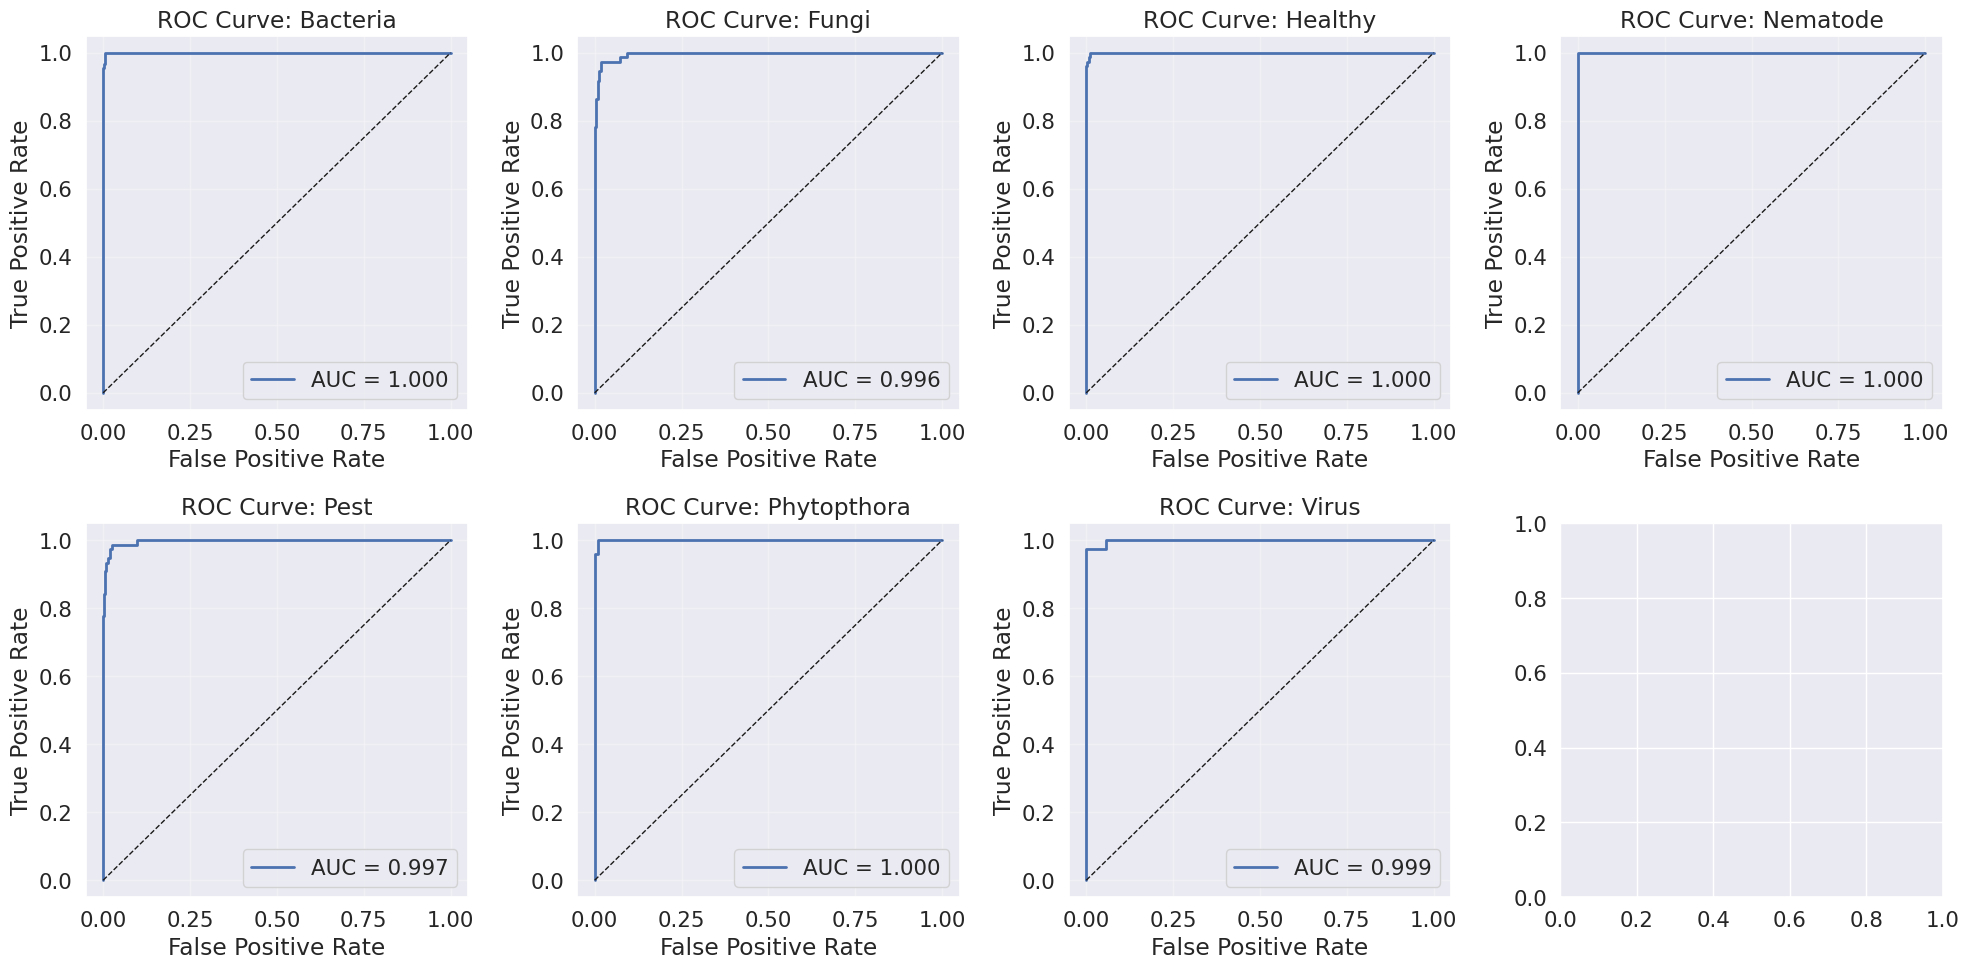

In [ ]:
# ===== CELL 21: ROC Curves =====
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, cls in enumerate(class_names):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)

    axes[i].plot(fpr, tpr, linewidth=2, label=f'AUC = {roc_auc:.3f}')
    axes[i].plot([0, 1], [0, 1], 'k--', linewidth=1)
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_title(f'ROC Curve: {cls}')
    axes[i].legend()
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [ ]:
# Save in native Keras format
model.save("efficientnet_potato_leaf_model.keras")
print("Model saved in Keras format")

# Export SavedModel (for TFLite / TF Serving)
model.export("efficientnet_potato_leaf_model")
print("Model exported as SavedModel")


Model saved in Keras format
INFO:tensorflow:Assets written to: efficientnet_potato_leaf_model/assets


INFO:tensorflow:Assets written to: efficientnet_potato_leaf_model/assets


Saved artifact at 'efficientnet_potato_leaf_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  132772479259024: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132772479254608: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  132774981495376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132774981495184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132772610518352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132774911496592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132774981496336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132772610517968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132772610521040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132772610519696: TensorSpec(shape=(), dtype=tf.r

In [ ]:

# ===== CELL 23: Load Model and Test Inference =====
from tensorflow.keras.models import load_model

# Load the model
# loaded_model = load_model(model_path)
loaded_model  = load_model('/content/efficientnet_potato_leaf_model.keras')
print("\nModel loaded successfully!")

# Function to predict single image
def predict_image(model, img_path, class_names):
    """
    Predict class of a single image

    Args:
        model: Trained Keras model
        img_path: Path to image file
        class_names: List of class names

    Returns:
        Predicted class and confidence scores
    """
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Create batch dimension

    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = class_names[predicted_class_idx]
    confidence = predictions[0][predicted_class_idx]

    # Display results
    plt.figure(figsize=(12, 4))

    # Show image
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f'Predicted: {predicted_class}\nConfidence: {confidence:.2%}',
              fontweight='bold', fontsize=12)
    plt.axis('off')

    # Show confidence bar chart
    plt.subplot(1, 2, 2)
    plt.barh(class_names, predictions[0], color='skyblue', edgecolor='black')
    plt.xlabel('Confidence Score')
    plt.title('Class Probabilities', fontweight='bold', fontsize=12)
    plt.xlim(0, 1)

    # Highlight predicted class
    plt.barh(predicted_class, confidence, color='green', edgecolor='black')

    plt.tight_layout()
    plt.show()

    return predicted_class, confidence, predictions[0]



Model loaded successfully!



Testing inference on: /kaggle/input/potato-leaf-disease-original-augmented/Dataset/Nematode/IMG_8333_aug9.jpg


E0000 00:00:1765696581.125940     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765696581.269114     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1765696581.401216     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


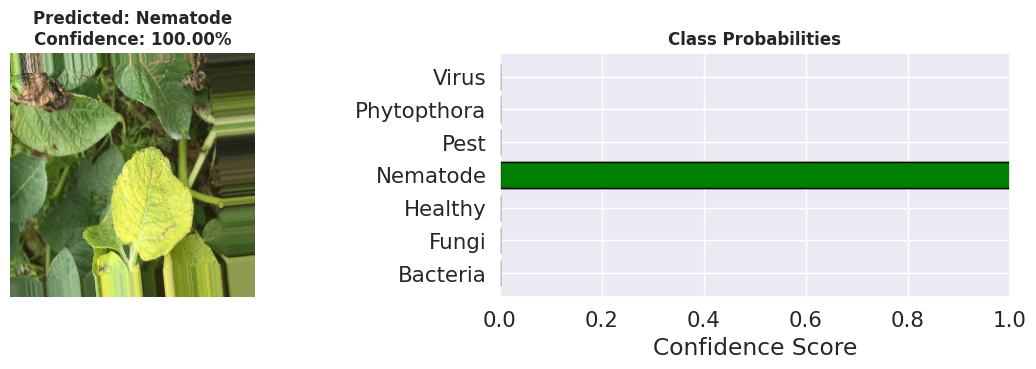


Predicted Class: Nematode
Confidence: 100.00%

All Class Probabilities:
  Bacteria: 0.0000
  Fungi: 0.0000
  Healthy: 0.0000
  Nematode: 1.0000
  Pest: 0.0000
  Phytopthora: 0.0000
  Virus: 0.0000

✅ Complete! Model training, evaluation, and inference pipeline finished successfully.


In [ ]:

# ===== CELL 24: Test on Sample Image =====
# Get a test image path from the dataset
test_image_path = None
for cls in os.listdir(DATASET_PATH):
    cls_path = os.path.join(DATASET_PATH, cls)
    if os.path.isdir(cls_path):
        images = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
        if images:
            test_image_path = os.path.join(cls_path, images[0])
            break

if test_image_path:
    print(f"\nTesting inference on: {test_image_path}")
    predicted_class, confidence, all_probs = predict_image(loaded_model, test_image_path, class_names)

    print(f"\nPredicted Class: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")
    print("\nAll Class Probabilities:")
    for cls, prob in zip(class_names, all_probs):
        print(f"  {cls}: {prob:.4f}")
else:
    print("No test image found in dataset")

print("\n✅ Complete! Model training, evaluation, and inference pipeline finished successfully.")


# server

In [ ]:
!pip install fastapi uvicorn pyngrok python-multipart pillow


In [ ]:
# --- FastAPI + Cloudflare Tunnel in Colab ---

from fastapi import FastAPI, File, UploadFile
from PIL import Image
import numpy as np
import io
import os
from tensorflow.keras.models import load_model
import tensorflow as tf
import nest_asyncio
import uvicorn
import threading
import subprocess
import re
import time

# Silence TensorFlow warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Load model
MODEL_PATH = "/content/efficientnet_potato_leaf_model.keras"
model = load_model(MODEL_PATH)

CLASS_NAMES = ["Bacteria", "Fungi", "Healthy", "Nematode", "Pest", "Phytopthora", "Virus"]
IMAGE_SIZE = 256

# Prediction function
def predict_disease(image: Image.Image):
    img = image.resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    preds = model.predict(img_array, verbose=0)
    return CLASS_NAMES[np.argmax(preds[0])]

# FastAPI app
app = FastAPI(title="Potato Leaf Disease Classifier")

@app.get("/health")
async def health_check():
    return {"status": "ok by abir"}

@app.post("/predict")
async def predict(file: UploadFile = File(...)):
    try:
        img_bytes = await file.read()
        image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        disease_name = predict_disease(image)
        return {"disease": disease_name}
    except Exception as e:
        return {"error": str(e)}

# --- Run FastAPI in background thread ---
nest_asyncio.apply()
def run_app():
    uvicorn.run(app, host="0.0.0.0", port=8001)
threading.Thread(target=run_app, daemon=True).start()

# --- Install Cloudflare tunnel ---
!wget -q https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

# --- Start tunnel ---
print("Starting Cloudflare tunnel...")
cf_process = subprocess.Popen(
    ["cloudflared", "tunnel", "--url", "http://localhost:8000"],
    stdout=subprocess.PIPE,
    stderr=subprocess.STDOUT,
    universal_newlines=True
)

# Wait for the public URL
public_url = None
start_time = time.time()
while time.time() - start_time < 20:
    line = cf_process.stdout.readline()
    if line:
        match = re.search(r'https://[^\s]+trycloudflare\.com', line)
        if match:
            public_url = match.group(0)
            break

if public_url:
    print("✅ Your FastAPI app is live at:", public_url)
else:
    print("❌ Could not get Cloudflare tunnel URL.")


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
INFO:     Started server process [257]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


Selecting previously unselected package cloudflared.
(Reading database ... 117528 files and directories currently installed.)
Preparing to unpack cloudflared-linux-amd64.deb ...
Unpacking cloudflared (2025.11.1) ...
Setting up cloudflared (2025.11.1) ...
Processing triggers for man-db (2.10.2-1) ...
Starting Cloudflare tunnel...
✅ Your FastAPI app is live at: https://scanning-shapes-nearest-featured.trycloudflare.com
